# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 6      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7464.91015625
iteration 0 loss 630626.6875


iteration 5000 loss 30.370792388916016


iteration 10000 loss 15.733076095581055


iteration 15000 loss 2.986319065093994


iteration 20000 loss 0.00545587157830596


iteration 25000 loss 0.00018996729340869933


iteration 30000 loss 9.98192081169691e-06


iteration 35000 loss 6.1335904320003465e-06


iteration 40000 loss 2.8500328426162014e-06


iteration 45000 loss 0.00014100167027208954


iteration 50000 loss 0.00012467996566556394


iteration 55000 loss 3.2849229683051817e-06


iteration 60000 loss 0.0008760467171669006


iteration 65000 loss 0.089914970099926


iteration 70000 loss 4.017511400888907e-06


iteration 75000 loss 2.602910853966023e-06


iteration 80000 loss 7.129911864467431e-06


iteration 85000 loss 0.019896142184734344


iteration 90000 loss 2.99559051200049e-05


iteration 95000 loss 1.4089734577282798e-05


iteration 100000 loss 6.269655841606436e-06


iteration 105000 loss 4.362525487522362e-06


iteration 110000 loss 6.970524736971129e-06


iteration 115000 loss 3.2584059681539657e-06


iteration 120000 loss 2.468656248311163e-06


iteration 125000 loss 0.34356391429901123


iteration 130000 loss 7.536802968388656e-06


iteration 135000 loss 6.817198936914792e-06


iteration 140000 loss 3.1310710255638696e-06


iteration 145000 loss 2.41543966694735e-05


iteration 150000 loss 0.0002527819015085697


iteration 155000 loss 0.3026180565357208


iteration 160000 loss 4.9713307817000896e-05


iteration 165000 loss 0.001017947681248188


iteration 170000 loss 0.022695571184158325


iteration 175000 loss 2.3132004116632743e-06


iteration 180000 loss 0.0012096329592168331


iteration 185000 loss 2.549513283156557e-06


iteration 190000 loss 0.00027306698029860854


iteration 195000 loss 6.877206033095717e-05


iteration 200000 loss 3.2784423638076987e-06


iteration 205000 loss 1.0336762898077723e-05


iteration 210000 loss 2.066730985461618e-06


iteration 215000 loss 8.014882951101754e-06


iteration 220000 loss 2.4042958557402017e-06


iteration 225000 loss 0.00021701892546843737


iteration 230000 loss 0.015964705497026443


iteration 235000 loss 0.011992448009550571


iteration 240000 loss 2.042808318947209e-06


iteration 245000 loss 2.623042291816091e-06


iteration 250000 loss 1.7915102716870024e-06


iteration 255000 loss 3.4415438676660415e-06


iteration 260000 loss 0.0012771629262715578


iteration 265000 loss 0.001690334058366716


iteration 270000 loss 2.04927255254006e-06


iteration 275000 loss 2.2672149952995824e-06


iteration 280000 loss 2.073573341476731e-06


iteration 285000 loss 3.785531134781195e-06


iteration 290000 loss 0.043647702783346176


iteration 295000 loss 2.4890848635550356e-06


iteration 300000 loss 0.053479187190532684


iteration 305000 loss 0.06095011532306671


iteration 310000 loss 2.0284601305320393e-06


iteration 315000 loss 0.008167777210474014


iteration 320000 loss 7.2377201831841376e-06


iteration 325000 loss 0.0008716016309335828


iteration 330000 loss 0.0006153275026008487


iteration 335000 loss 5.066991889179917e-06


iteration 340000 loss 7.681484021304641e-06


iteration 345000 loss 8.922394044930115e-05


iteration 350000 loss 5.723152753489558e-06


iteration 355000 loss 0.0003975295403506607


iteration 360000 loss 3.831990852631861e-06


iteration 365000 loss 0.006098580546677113


iteration 370000 loss 2.362744908168679e-06


iteration 375000 loss 0.00018038555572275072


iteration 380000 loss 5.036078164266655e-06


iteration 385000 loss 0.03429107367992401


iteration 390000 loss 0.0004881363711319864


iteration 395000 loss 0.00030198029708117247


iteration 400000 loss 1.3396130498222192e-06


iteration 405000 loss 2.8039527023793198e-05


iteration 410000 loss 0.207095205783844


iteration 415000 loss 4.140858891332755e-06


iteration 420000 loss 0.00015411929052788764


iteration 425000 loss 7.628527964698151e-05


iteration 430000 loss 1.4656109215138713e-06


iteration 435000 loss 1.3443476746033411e-05


iteration 440000 loss 0.0009106340003199875


iteration 445000 loss 6.28182096988894e-05


iteration 450000 loss 1.7837031691669836e-06


iteration 455000 loss 1.2050888926751213e-06


iteration 460000 loss 5.66163635085104e-06


iteration 465000 loss 0.0002930618356913328


iteration 470000 loss 2.24753284783219e-06


iteration 475000 loss 4.740961594507098e-05


iteration 480000 loss 0.0701635479927063


iteration 485000 loss 1.2525431429821765e-06


iteration 490000 loss 5.593423338723369e-06


iteration 495000 loss 1.1284735137451207e-06


L2 loss -- Plot

loss -32.381675720214844


loss -269.1790771484375


loss -391.066162109375


loss -480.66790771484375


loss -561.4117431640625


loss -634.615234375


loss -697.8489990234375


loss -748.2511596679688


loss -786.7484741210938


loss -815.0369873046875


loss -834.3665771484375


loss -846.44482421875


loss -853.3072509765625


loss -856.8883056640625


loss -858.6163330078125


loss -859.3818359375


loss -859.68701171875


loss -859.7928466796875


loss -859.8231201171875


loss -859.82958984375


loss -859.8306274414062


loss -859.8306274414062


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


loss -859.8306884765625


final mse:  1.577558639276333e-09
max, min: 5.6744647 -6.449964
loss -32.381675720214844


loss -270.08367919921875


loss -390.77825927734375


loss -479.97552490234375


loss -560.2615966796875


loss -633.4412841796875


loss -697.8338623046875


loss -751.038818359375


loss -792.691650390625


loss -823.5574951171875


loss -845.0139770507812


loss -859.0452270507812


loss -867.70703125


loss -872.7635498046875


loss -875.5338134765625


loss -876.9312744140625


loss -877.560546875


loss -877.8033447265625


loss -877.8795166015625


loss -877.897705078125


loss -877.9007568359375


loss -877.9010009765625


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.9010620117188


loss -877.901123046875


final mse:  4.445999401969658e-10
max, min: 5.759107 -6.779236


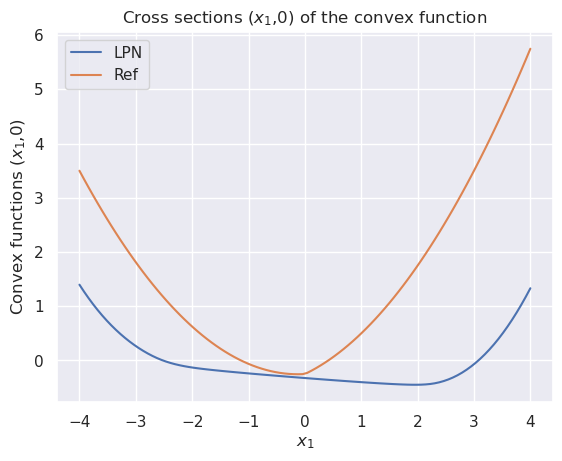

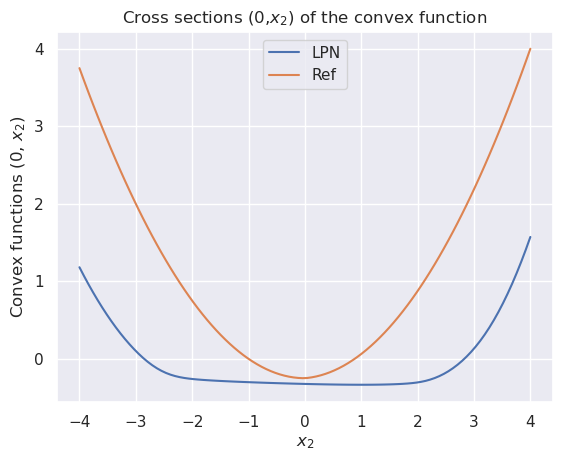

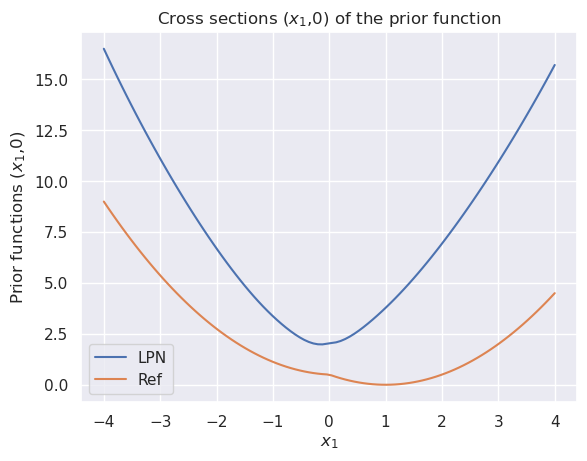

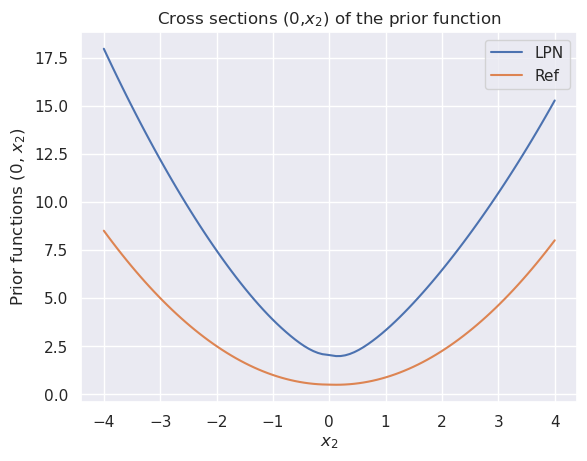

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2821.001220703125
iteration 0 loss 52535.3984375


iteration 5000 loss 3.145498037338257


iteration 10000 loss 1.0557717084884644


iteration 15000 loss 0.178324893116951


iteration 20000 loss 0.04083213582634926


iteration 25000 loss 0.014429171569645405


iteration 30000 loss 0.007290287408977747


iteration 35000 loss 0.017786987125873566


iteration 40000 loss 0.002482573501765728


iteration 45000 loss 0.0015593298012390733


iteration 50000 loss 0.001007375307381153


iteration 55000 loss 0.0006666977424174547


iteration 60000 loss 0.00045511338976211846


iteration 65000 loss 0.00030997046269476414


iteration 70000 loss 0.0008992545772343874


iteration 75000 loss 0.00015076607814989984


iteration 80000 loss 0.00010672037024050951


iteration 85000 loss 0.019836442545056343


iteration 90000 loss 5.524556399905123e-05


iteration 95000 loss 3.9603728509973735e-05


iteration 100000 loss 2.9449647627188824e-05


iteration 105000 loss 0.005478992592543364


iteration 110000 loss 1.7724689314491116e-05


iteration 115000 loss 1.3483037037076429e-05


iteration 120000 loss 1.120759861805709e-05


iteration 125000 loss 8.937519851315301e-06


iteration 130000 loss 6.727105301251868e-06


iteration 135000 loss 7.334269412240246e-06


iteration 140000 loss 7.761024789942894e-06


iteration 145000 loss 4.1070793486142065e-06


iteration 150000 loss 4.077426183357602e-06


iteration 155000 loss 0.1520703285932541


iteration 160000 loss 4.0464110497850925e-06


iteration 165000 loss 3.2531693250348326e-06


iteration 170000 loss 2.4126420612446964e-06


iteration 175000 loss 0.023937365040183067


iteration 180000 loss 3.2653354082867736e-06


iteration 185000 loss 2.191729436162859e-06


iteration 190000 loss 1.9542649170034565e-06


iteration 195000 loss 2.9069431093375897e-06


iteration 200000 loss 2.3719810542388586e-06


iteration 205000 loss 2.105138037222787e-06


iteration 210000 loss 2.105593694068375e-06


iteration 215000 loss 1.7507793472759658e-06


iteration 220000 loss 1.6852417275003972e-06


iteration 225000 loss 1.900129791465588e-05


iteration 230000 loss 4.971213456883561e-06


iteration 235000 loss 2.899496166719473e-06


iteration 240000 loss 2.177752321586013e-06


iteration 245000 loss 1.7824038422986632e-06


iteration 250000 loss 1.5734243561382755e-06


iteration 255000 loss 9.506838978268206e-06


iteration 260000 loss 3.647246558102779e-06


iteration 265000 loss 2.003865120059345e-06


iteration 270000 loss 1.7800757632358e-06


iteration 275000 loss 1.7978466075874167e-06


iteration 280000 loss 1.6522894838999491e-06


iteration 285000 loss 1.5560101473965915e-06


iteration 290000 loss 1.608025058885687e-06


iteration 295000 loss 3.095112560913549e-06


iteration 300000 loss 2.9296393222466577e-06


iteration 305000 loss 2.477406951584271e-06


iteration 310000 loss 2.48249261858291e-06


iteration 315000 loss 2.0544130165944807e-06


iteration 320000 loss 2.0537238469842123e-06


iteration 325000 loss 1.8003443074121606e-06


iteration 330000 loss 1.7197376109834295e-06


iteration 335000 loss 1.691321813268587e-06


iteration 340000 loss 1.69083216405852e-06


iteration 345000 loss 1.561108206260542e-06


iteration 350000 loss 0.01778930239379406


iteration 355000 loss 5.336414233170217e-06


iteration 360000 loss 0.0009596055606380105


iteration 365000 loss 1.583368657520623e-06


iteration 370000 loss 1.6022349882405251e-06


iteration 375000 loss 1.69595568877412e-06


iteration 380000 loss 1.6595673741903738e-06


iteration 385000 loss 1.6990979929687455e-06


iteration 390000 loss 1.915687334985705e-06


iteration 395000 loss 2.5996439489972545e-06


iteration 400000 loss 2.3509242055297364e-06


iteration 405000 loss 1.7476980929131969e-06


iteration 410000 loss 1.7628472051001154e-06


iteration 415000 loss 1.6593184000157635e-06


iteration 420000 loss 1.4855177141726017e-06


iteration 425000 loss 1.549638795950159e-06


iteration 430000 loss 1.5008786249381956e-06


iteration 435000 loss 1.5782925402163528e-06


iteration 440000 loss 1.4999741324572824e-06


iteration 445000 loss 1.6071900290626218e-06


iteration 450000 loss 1.5817180383237428e-06


iteration 455000 loss 1.5458615507668583e-06


iteration 460000 loss 1.4194858977134572e-06


iteration 465000 loss 1.5394397223644773e-06


iteration 470000 loss 1.8290274965693243e-06


iteration 475000 loss 1.893776925498969e-06


iteration 480000 loss 1.7069532987079583e-06


iteration 485000 loss 1.6167733747352031e-06


iteration 490000 loss 1.9883602817571955e-06


iteration 495000 loss 3.8119062537589343e-06


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


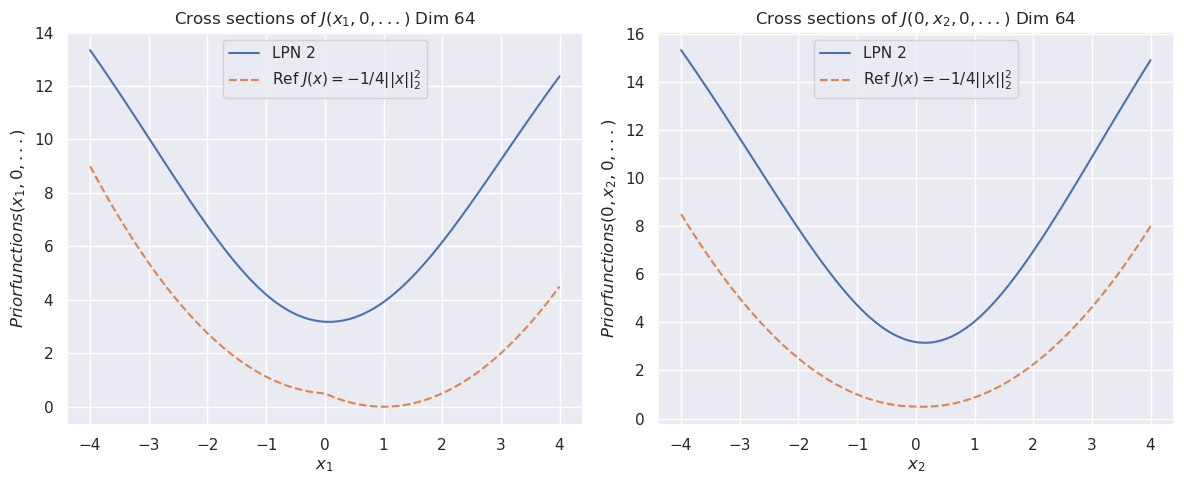

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)